### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings, Random, Dierckx
include("STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("STG_models.jl") # Loading of STG model
include("STG_utils.jl") # Loading of some utils functions
include("STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("STG_neuromodulation.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 300000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1)
default(fmt = :png)

# Moving average function
moving_average(vs, n, padding) = [sum(vs[i:(i+n-1)])/n for i in 1:padding:(length(vs)-(n-1))];

# **Neuromodulation gCaS and gA overall**

## **Computation of gCaS and gA**

In [3]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth);
# create a spiking set with max variability in gCaS and gA

In [4]:
# Definition of parameters
α = 5e-3 # Rate of transfer between intracellular and membrane
β = 5e-3 # Rate of degradation of intracellular proteins
Kp = 3e-4 # Proprtional gain
Ki = 5e-6 # Integral gain
Kt = β / Ki # Anti-windup gain
gsth_sim(t) = 5. - 13. * pulse(t, Tfinal/2, Tfinal) # Reference
guth_sim(t) = 4.
u_maxCaS = 1e7 # Maximum value of actuator
u_maxA = 1e7

# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
Ca_tgt(t) = 125. # Calcium target

# Input current definition
Iapp = 0.

tt = 0. : 0.2 : 50000.

tt2 = 0. : 0.2 : Tfinal
end_i = findall(tt2.==60000)[1]

tt_s = 0. : 0.1 : 80.;

## **Simulation to prove that homeostasis crashes, neuron 1**

In [5]:
Random.seed!(1234)
# Extracting the maximal ion channel conductances
rng_i = mod(rand(Int, 1)[1], ncells) + 1
(gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak) = g_all_init[rng_i, :];

In [6]:
# Definition of homeostatic parameters
tau_Na = 600 # Integral action time constants
tau_CaT = tau_Na * gNa / gCaT
tau_KCa = tau_Na * gNa / gKCa
tau_Kd = tau_Na * gNa / gKd
tau_H = tau_Na * gNa / gH
tau_leak = tau_Na * gNa / gleak
tau_CaS = tau_Na * gNa / gCaS
tau_A = tau_Na * gNa / gA;

In [7]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
p1 = [Iapp, tau_Na, tau_CaT, tau_KCa, tau_Kd, tau_H, tau_leak, tau_g, Ca_tgt, C, α, β, 
      Kp, Ki, Kt, gsth_sim, guth_sim, ICs_th_init[:, 1][rng_i], u_maxCaS, u_maxA]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x01  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
        hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
        gNa, gCaT, gKCa, gKd, gH, gleak, gNa, gCaT, gKCa, gKd, gH, gleak, 
        gCaS, gCaS, (β * gCaS) / Ki, gA, gA, (β * gA) / Ki]

# Simulation
prob1 = ODEProblem(simple_PI_homeo_leak_STG_ODE, x01, tspan, p1) # Describing the problem
sol1 = solve(prob1); # Solving the problem

In [8]:
# Retrieving variables
tt            = 0. : 0.2 : Tfinal
x1            = sol1(tt)
VV_plot1      = x1[1, :]
Ca_plot1      = x1[13, :]
gNa_plot1     = x1[14, :]
gCaT_plot1    = x1[15, :]
gKCa_plot1    = x1[16, :]
gKd_plot1     = x1[17, :]
gH_plot1      = x1[18, :]
gleak_plot1   = x1[19, :]
gCaS_plot1    = x1[27, :]
zCaS_plot1    = x1[28, :]
gA_plot1      = x1[30, :]
zA_plot1      = x1[31, :];

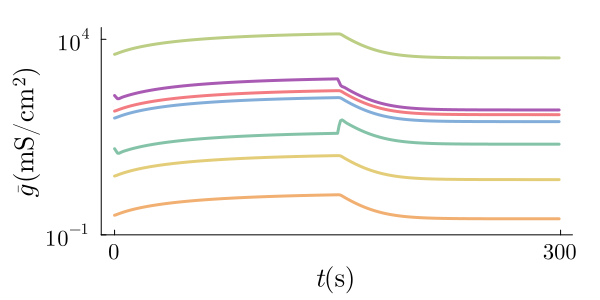

In [9]:
pp1 = plot(ylims=(1e-1, 2e4), yticks=([1e-1, 1e4], [L"10^{-1}", L"10^{4}"]), guidefontsize=18,
           xticks=([0, 300], [L"0", L"300"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt[2:5000:end]/1e3, gA_plot1[2:5000:end], color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gCaS_plot1[2:5000:end], color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gNa_plot1[2:5000:end], color=myApple, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gCaT_plot1[2:5000:end], color=myYellow, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gKCa_plot1[2:5000:end], color=myBlue, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gKd_plot1[2:5000:end], color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gH_plot1[2:5000:end], color=myOrange, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp1)
# savefig(pp1, "./figures/crash_g_all_1.pdf")

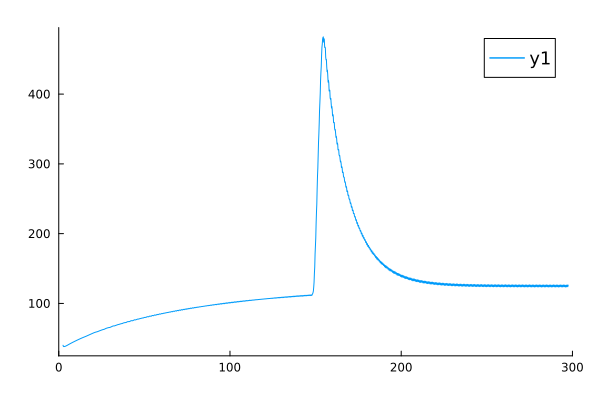

In [10]:
window_size_s = 5
padding_s = 0.2
window_size = Int64(round(window_size_s*1000*length(tt)/Tfinal))
padding = Int64(round(padding_s*1000*length(tt)/Tfinal))
tt_moving_average = window_size_s/2 : padding_s : Tfinal/1000 - window_size_s/2

Ca_average_plot = moving_average(Ca_plot1, window_size, padding)

plot(tt_moving_average, Ca_average_plot, xlims=(0, Tfinal/1e3))

In [11]:
gNa_blockade_init = gNa_plot1[end]
gCaT_blockade_init = gCaT_plot1[end]
gCaS_blockade_init = gCaS_plot1[end]
gA_blockade_init = gA_plot1[end]
gKCa_blockade_init = gKCa_plot1[end]
gKd_blockade_init = gKd_plot1[end]
gH_blockade_init = gH_plot1[end]
gleak_blockade_init = gleak_plot1[end];

In [12]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
gsth_sim2(t) = -8.
guth_sim2(t) = -4.
p1_2 = [Iapp, tau_Na, tau_CaT, tau_KCa, tau_Kd, tau_H, tau_leak, tau_g, Ca_tgt, C, α, β, 
        Kp, Ki, Kt, gsth_sim2, guth_sim2, ICs_th_init[:, 1][rng_i], u_maxCaS, u_maxA]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x01_2  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
          hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
          gNa_blockade_init, gCaT_blockade_init, gKd_blockade_init, 
          gKCa_blockade_init, gleak_blockade_init, gNa_blockade_init, gCaT_blockade_init, 
          gKd_blockade_init, gKCa_blockade_init, gleak_blockade_init, 
          gCaS_blockade_init, gCaS_blockade_init, (β * gCaS_blockade_init) / Ki, 
          gA_blockade_init, gA_blockade_init, (β * gA_blockade_init) / Ki]

# Simulation
prob1_2 = ODEProblem(H_blockade_STG_ODE, x01_2, (0., Tfinal/3), p1_2) # Describing the problem
sol1_2 = solve(prob1_2); # Solving the problem

In [13]:
# Retrieving variables
tt_           = 0. : 0.2 : Tfinal/3
x1_2          = sol1_2(tt_)
VV_plot1_2    = x1_2[1, :]
Ca_plot1_2    = x1_2[13, :]
gNa_plot1_2   = x1_2[14, :]
gCaT_plot1_2  = x1_2[15, :]
gKCa_plot1_2  = x1_2[16, :]
gKd_plot1_2   = x1_2[17, :]
gleak_plot1_2 = x1_2[18, :]
gCaS_plot1_2  = x1_2[25, :]
zCaS_plot1_2  = x1_2[26, :]
gA_plot1_2    = x1_2[28, :]
zA_plot1_2    = x1_2[29, :];

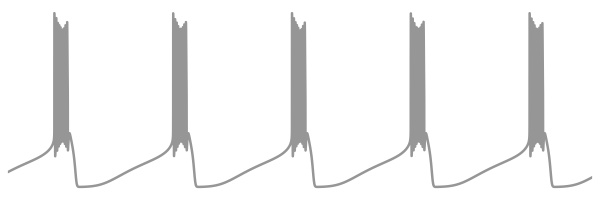

In [14]:
p = plot(tt_/1e3, VV_plot1_2, xlims=(98, 100), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_H_blockade3.pdf")

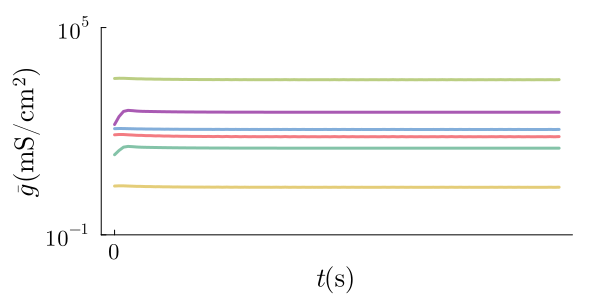

In [15]:
pp1 = plot(ylims=(1e-1, 1e5), yticks=([1e-1, 1e5], [L"10^{-1}", L"10^{5}"]), guidefontsize=18,
           xticks=([0, 300], [L"0", L"300"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt_[2:5000:end]/1e3, gA_plot1_2[2:5000:end], color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gCaS_plot1_2[2:5000:end], color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gNa_plot1_2[2:5000:end], color=myApple, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gCaT_plot1_2[2:5000:end], color=myYellow, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gKCa_plot1_2[2:5000:end], color=myBlue, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gKd_plot1_2[2:5000:end], color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp1)
# savefig(pp1, "./figures/crash_g_all_1.pdf")

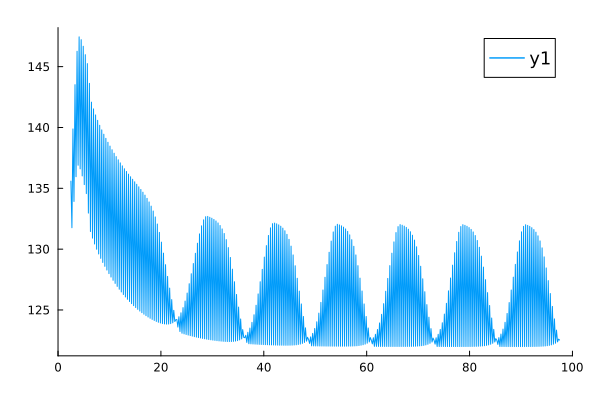

In [16]:
window_size_s = 5
padding_s = 0.2
window_size_ = Int64(round(window_size_s*1000*length(tt_)/(Tfinal/3)))
padding_ = Int64(round(padding_s*1000*length(tt_)/(Tfinal/3)))
tt_moving_average_ = window_size_s/2 : padding_s : Tfinal/3000 - window_size_s/2

Ca_average_plot2 = moving_average(Ca_plot1_2, window_size_, padding_)

plot(tt_moving_average_, Ca_average_plot2, xlims=(0, Tfinal/3e3))

In [17]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
gsth_sim3(t) = -10.
guth_sim3(t) = 3.
p1_3 = [Iapp, tau_Na, tau_CaT, tau_KCa, tau_Kd, tau_H, tau_leak, tau_g, Ca_tgt, C, α, β, 
        Kp, Ki, Kt, gsth_sim3, guth_sim3, ICs_th_init[:, 1][rng_i], u_maxCaS, u_maxA]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x01_3  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
          hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
          gNa_blockade_init, gKCa_blockade_init, gKd_blockade_init, gH_blockade_init, 
          gleak_blockade_init, gNa_blockade_init, gKCa_blockade_init, 
          gKd_blockade_init, gH_blockade_init, gleak_blockade_init, 
          gCaS_blockade_init, gCaS_blockade_init, (β * gCaS_blockade_init) / Ki, 
          gA_blockade_init, gA_blockade_init, (β * gA_blockade_init) / Ki]

# Simulation
prob1_3 = ODEProblem(CaT_blockade_STG_ODE, x01_3, (0., Tfinal/3), p1_3) # Describing the problem
sol1_3 = solve(prob1_3); # Solving the problem

In [18]:
# Retrieving variables
x1_3          = sol1_3(tt_)
VV_plot1_3    = x1_3[1, :]
Ca_plot1_3    = x1_3[13, :]
gNa_plot1_3   = x1_3[14, :]
gKCa_plot1_3  = x1_3[15, :]
gKd_plot1_3   = x1_3[16, :]
gH_plot1_3    = x1_3[17, :]
gleak_plot1_3 = x1_3[18, :]
gCaS_plot1_3  = x1_3[25, :]
zCaS_plot1_3  = x1_3[26, :]
gA_plot1_3    = x1_3[28, :]
zA_plot1_3    = x1_3[29, :];

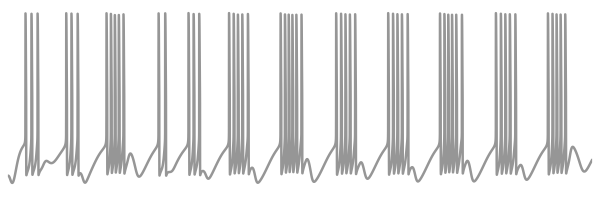

In [19]:
p = plot(tt_/1e3, VV_plot1_3, xlims=(72.26, 74.05), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_CaT_blockade3.pdf")

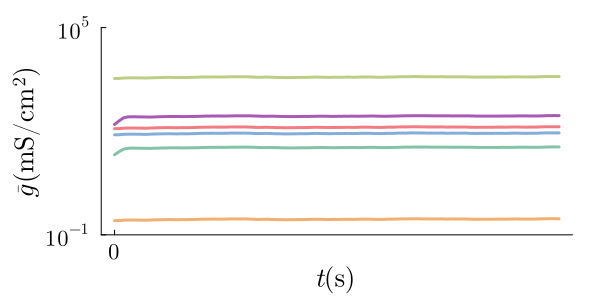

In [20]:
pp1 = plot(ylims=(1e-1, 1e5), yticks=([1e-1, 1e5], [L"10^{-1}", L"10^{5}"]), guidefontsize=18,
           xticks=([0, 300], [L"0", L"300"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt_[2:5000:end]/1e3, gA_plot1_3[2:5000:end], color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gCaS_plot1_3[2:5000:end], color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gNa_plot1_3[2:5000:end], color=myApple, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gKCa_plot1_3[2:5000:end], color=myBlue, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gKd_plot1_3[2:5000:end], color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gH_plot1_3[2:5000:end], color=myOrange, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp1)
# savefig(pp1, "./figures/crash_g_all_1.pdf")

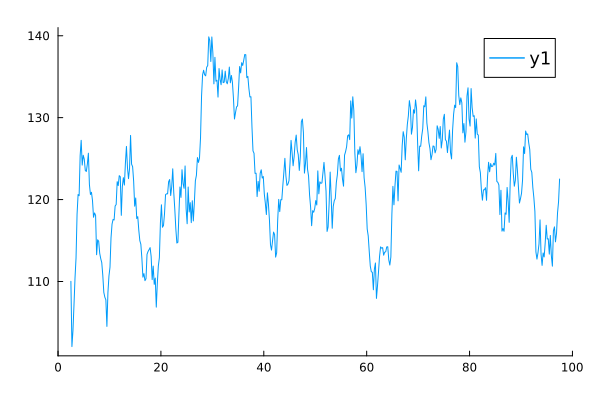

In [21]:
window_size_s = 5
padding_s = 0.2
window_size_ = Int64(round(window_size_s*1000*length(tt_)/(Tfinal/3)))
padding_ = Int64(round(padding_s*1000*length(tt_)/(Tfinal/3)))
tt_moving_average_ = window_size_s/2 : padding_s : Tfinal/3000 - window_size_s/2

Ca_average_plot3 = moving_average(Ca_plot1_3, window_size_, padding_)

plot(tt_moving_average_, Ca_average_plot3, xlims=(0, Tfinal/3e3))

In [22]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
gsth_sim4(t) = -8.
guth_sim4(t) = 4.
p1_4 = [Iapp, tau_Na, tau_CaT, tau_KCa, tau_Kd, tau_H, tau_leak, tau_g, Ca_tgt, C, α, β, 
        Kp, Ki, Kt, gsth_sim4, guth_sim4, ICs_th_init[:, 1][rng_i], u_maxCaS, u_maxA]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x01_4  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
          hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
          gCaT_blockade_init, gKCa_blockade_init, gKd_blockade_init, gH_blockade_init, 
          gleak_blockade_init, gCaT_blockade_init, gKCa_blockade_init, 
          gKd_blockade_init, gH_blockade_init, gleak_blockade_init, 
          gCaS_blockade_init, gCaS_blockade_init, (β * gCaS_blockade_init) / Ki, 
          gA_blockade_init, gA_blockade_init, (β * gA_blockade_init) / Ki]

# Simulation
prob1_4 = ODEProblem(Na_blockade_STG_ODE, x01_4, (0., Tfinal), p1_4) # Describing the problem
sol1_4 = solve(prob1_4); # Solving the problem

In [23]:
# Retrieving variables
x1_4          = sol1_4(tt)
VV_plot1_4    = x1_4[1, :]
Ca_plot1_4    = x1_4[13, :]
gCaT_plot1_4  = x1_4[14, :]
gKCa_plot1_4  = x1_4[15, :]
gKd_plot1_4   = x1_4[16, :]
gH_plot1_4    = x1_4[17, :]
gleak_plot1_4 = x1_4[18, :]
gCaS_plot1_4  = x1_4[25, :]
zCaS_plot1_4  = x1_4[26, :]
gA_plot1_4    = x1_4[28, :]
zA_plot1_4    = x1_4[29, :];

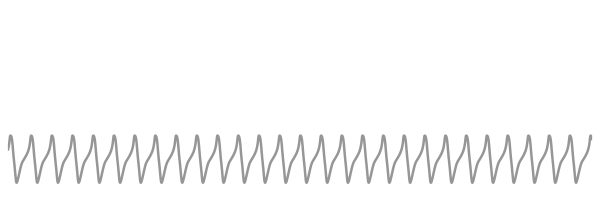

In [24]:
p = plot(tt/1e3, VV_plot1_4, xlims=(45, 50), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px, ylims=(-80, 100))
display(p)
# savefig(p, "./figures/STG_Na_blockade3.pdf")

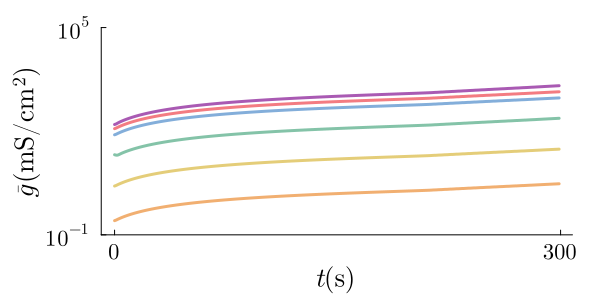

In [25]:
pp1 = plot(ylims=(1e-1, 1e5), yticks=([1e-1, 1e5], [L"10^{-1}", L"10^{5}"]), guidefontsize=18,
           xticks=([0, 300], [L"0", L"300"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt[2:5000:end]/1e3, gA_plot1_4[2:5000:end], color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gCaS_plot1_4[2:5000:end], color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gCaT_plot1_4[2:5000:end], color=myYellow, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gKCa_plot1_4[2:5000:end], color=myBlue, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gKd_plot1_4[2:5000:end], color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt[2:5000:end]/1e3, gH_plot1_4[2:5000:end], color=myOrange, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp1)
# savefig(pp1, "./figures/crash_g_all_1.pdf")

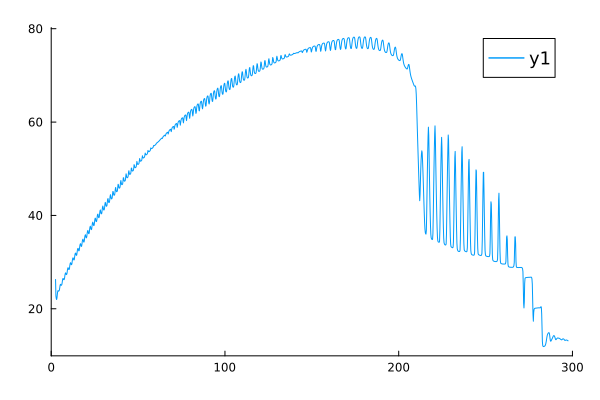

In [26]:
window_size_s = 5
padding_s = 0.2
window_size = Int64(round(window_size_s*1000*length(tt)/(Tfinal)))
padding = Int64(round(padding_s*1000*length(tt)/(Tfinal)))
tt_moving_average = window_size_s/2 : padding_s : Tfinal/1000 - window_size_s/2

Ca_average_plot4 = moving_average(Ca_plot1_4, window_size, padding)

plot(tt_moving_average, Ca_average_plot4, xlims=(0, Tfinal/1e3))

In [27]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
gsth_sim5(t) = -8.
guth_sim5(t) = -4.
p1_5 = [Iapp, tau_Na, tau_CaT, tau_KCa, tau_Kd, tau_H, tau_leak, tau_g, Ca_tgt, C, α, β, 
        Kp, Ki, Kt, gsth_sim5, guth_sim5, ICs_th_init[:, 1][rng_i], u_maxCaS, u_maxA]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x01_5  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
          hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
          gNa_blockade_init, gCaT_blockade_init, gKd_blockade_init, gH_blockade_init, 
          gleak_blockade_init, gNa_blockade_init, gCaT_blockade_init, 
          gKd_blockade_init, gH_blockade_init, gleak_blockade_init, 
          gCaS_blockade_init, gCaS_blockade_init, (β * gCaS_blockade_init) / Ki, 
          gA_blockade_init, gA_blockade_init, (β * gA_blockade_init) / Ki]

# Simulation
prob1_5 = ODEProblem(KCa_blockade_STG_ODE, x01_5, (0., Tfinal/3), p1_5) # Describing the problem
sol1_5 = solve(prob1_5); # Solving the problem

In [28]:
# Retrieving variables
x1_5          = sol1_5(tt_)
VV_plot1_5    = x1_5[1, :]
Ca_plot1_5    = x1_5[13, :]
gNa_plot1_5   = x1_5[14, :]
gCaT_plot1_5  = x1_5[15, :]
gKd_plot1_5   = x1_5[16, :]
gH_plot1_5    = x1_5[17, :]
gleak_plot1_5 = x1_5[18, :]
gCaS_plot1_5  = x1_5[25, :]
zCaS_plot1_5  = x1_5[26, :]
gA_plot1_5    = x1_5[28, :]
zA_plot1_5    = x1_5[29, :];

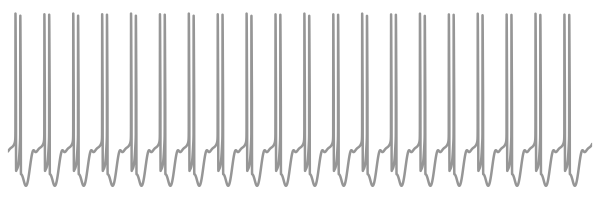

In [29]:
p = plot(tt_/1e3, VV_plot1_5, xlims=(98, 100), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGray, margins=0px)
display(p)
# savefig(p, "./figures/STG_KCa_blockade3.pdf")

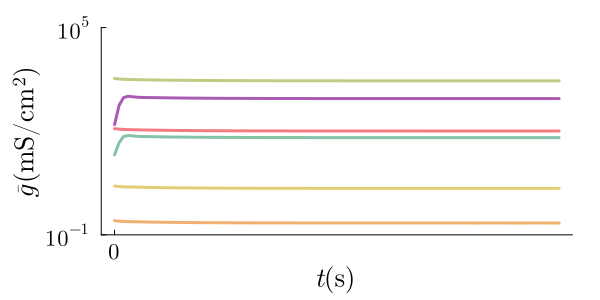

In [30]:
pp1 = plot(ylims=(1e-1, 1e5), yticks=([1e-1, 1e5], [L"10^{-1}", L"10^{5}"]), guidefontsize=18,
           xticks=([0, 300], [L"0", L"300"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt_[2:5000:end]/1e3, gA_plot1_5[2:5000:end], color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gCaS_plot1_5[2:5000:end], color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gNa_plot1_5[2:5000:end], color=myApple, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gCaT_plot1_5[2:5000:end], color=myYellow, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gKd_plot1_5[2:5000:end], color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_[2:5000:end]/1e3, gH_plot1_5[2:5000:end], color=myOrange, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp1)
# savefig(pp1, "./figures/crash_g_all_1.pdf")

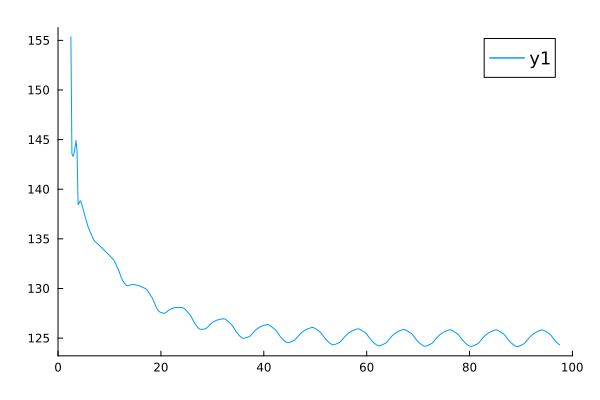

In [31]:
window_size_s = 5
padding_s = 0.2
window_size_ = Int64(round(window_size_s*1000*length(tt_)/(Tfinal/3)))
padding_ = Int64(round(padding_s*1000*length(tt_)/(Tfinal/3)))
tt_moving_average_ = window_size_s/2 : padding_s : Tfinal/3000 - window_size_s/2

Ca_average_plot5 = moving_average(Ca_plot1_5, window_size_, padding_)

plot(tt_moving_average_, Ca_average_plot5, xlims=(0, Tfinal/3e3))